<a href="https://colab.research.google.com/github/Deepak-Mewada/Hackathone/blob/main/EEG_Shape_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
from sklearn import preprocessing
#import tensorflow as tf
import numpy as np
import time
import pickle
import os
#import tensorflow.compat.v1 as tf1
#tf1.disable_v2_behavior()

In [ ]:
print(tf.__version__)

1.15.2


In [ ]:
"""
Data reading, all_01.dat, the first person (shape_01.pk), [3200, 2380],
each sample has 2380 features, 2380 = 10*14 + 40*56
"""
#data = np.load(open('all_01.dat', 'rb'),allow_pickle=True)
#with open('all_01.dat', 'rb') as f:
#     data = pickle.load(f, encoding='latin1')
data= pickle.load(open('all_01.dat', 'rb'),  encoding='iso-8859-1')

EEG = preprocessing.minmax_scale(data[:, :140], axis=1)
EEG = EEG * 2 - 1
ima = preprocessing.minmax_scale(data[:, 140:], axis=1)
data = np.hstack((EEG, ima))
img_size = 40 * 56
noise_size = 140
print(data.shape)

(3200, 2380)


In [ ]:
"""
This code is used to extract features from the raw EEG signals for further generation.
The raw signals has 140 = 10*14 dimensions, we can compress it to 40 dimension or fewer. 
"""

def one_hot(y_):
    # Function to encode output labels from number indexes
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    y_ = y_.reshape(len(y_))
    y_ = [int(x) for x in y_]
    n_values = np.max(y_) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]


# this function only calculate the acc of CNN_task
def compute_accuracy(v_xs, v_ys):
    global pred
    y_pre = sess.run(pred, feed_dict={xs: v_xs,})
    correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run(accuracy, feed_dict={xs: v_xs, ground: v_ys})
    return result


t1 = time.time()


"""
label making
"""
l0 = np.zeros([int(3200/5), 1])
for lab in range(1, 5):
    l_ = np.ones([int(3200/5), 1]) * lab
    l0 = np.vstack((l0, l_))

# concate with the label
data = np.hstack((data, l0))
np.random.shuffle(data)

n_class = 5
label = data[:, (img_size+noise_size):(img_size+noise_size)+1]
label = one_hot(label)
feature = data[:, :140]

# batch split
batch_size = label.shape[0]/5
train_fea = []
n_group = int(label.shape[0]/batch_size)

for i in range(n_group):
    f = feature[int(0+batch_size*i):int(batch_size+batch_size*i)]
    train_fea.append(f)
# print(train_fea[0].shape)

train_label=[]
for i in range(n_group):
    f = label[int(0 + batch_size * i):int(batch_size + batch_size * i), :]
    train_label.append(f)

# print(train_label[0].shape)
test_fea = train_fea[-1]
test_label = train_label[-1]

"""CNN classifier"""

xs = tf.placeholder(tf.float32, shape=[None, 140], name='input_EEG')
ground = tf.placeholder(tf.float32, shape=[None, n_class], name='ground_truth')

z_image = tf.reshape(xs, [-1, 10, 14, 1])
depth_1 = 32
depth_2 = 64
out_dim = 40
conv1 = tf.layers.conv2d(inputs=z_image, filters=depth_1, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=[2, 2])

conv2 = tf.layers.conv2d(inputs=pool1, filters=depth_2, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=[2, 2])

flatten = tf.contrib.layers.flatten(pool2)
flatten = tf.nn.dropout(flatten, 0.5)

fea = tf.layers.dense(flatten, out_dim, activation=tf.nn.sigmoid)

pred = tf.layers.dense(fea, n_class)

# cost and accuracy
l2 = 0.0005 * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=ground))+l2

train_step = tf.train.AdamOptimizer(0.0005).minimize(cost)

# use this to limit the GPU number

os.environ['CUDA_VISIBLE_DEVICES'] = '5'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

init = tf.global_variables_initializer()
sess.run(init)

step = 1
while step < 1000:
    for i in range(n_group-1):
        feed = feed_dict = {xs:train_fea[i], ground:train_label[i]}
        sess.run(train_step, feed_dict=feed)
    if step % 100 == 0:
        """ cost"""
        cost_train =sess.run(cost, feed_dict=feed)
        cost_test =sess.run(cost, feed_dict={xs:test_fea, ground:test_label})
        acc_test = compute_accuracy(test_fea, test_label)

        print('the step is:', step, 'train, test, acc task', compute_accuracy(train_fea[0], train_label[0]), acc_test
                , ', train test cost', cost_train, cost_test)
        if acc_test > 0.6:
            break

    step += 1
#
EEG_features = sess.run(fea, feed_dict={xs : data[:, :140]})
all_data = np.hstack((EEG_features, data[:, 140:]))

pickle.dump(all_data, open('shape_EEG_feature.pkl', 'wb'))
print('dumped as shape_EEG_feature.pkl', data.shape, all_data.shape, time.time() - t1)


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

the step

Epoch 51/500 D Loss: 0.0774(r/f: 0.0774 + category: 1.4083) G Loss: 4.8263, RMSE:0.0031 , C loss0.7666, acc, 0.1750 IC real.1.0000, fake: 0.3250
true label, [4. 4. 4. 3. 4. 2. 4. 2. 0.]
image saved [3. 4. 4. 4. 3. 4. 2. 4. 2. 0. 2. 0. 4. 1. 1. 1. 1. 4. 0. 0.]


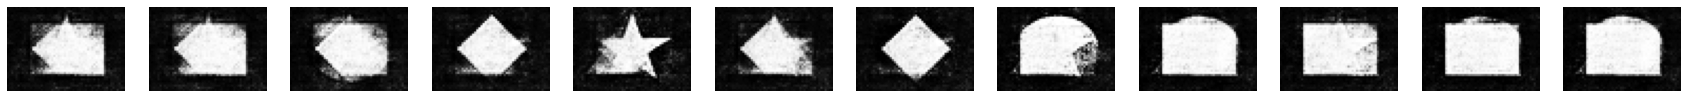

Epoch 101/500 D Loss: 0.6767(r/f: 0.6767 + category: 1.4374) G Loss: 4.0171, RMSE:0.0030 , C loss0.7667, acc, 0.1500 IC real.1.0000, fake: 0.3375
true label, [4. 4. 4. 3. 4. 2. 4. 2. 0.]
image saved [3. 4. 4. 4. 3. 4. 2. 4. 2. 0. 2. 0. 4. 1. 1. 1. 1. 4. 0. 0.]


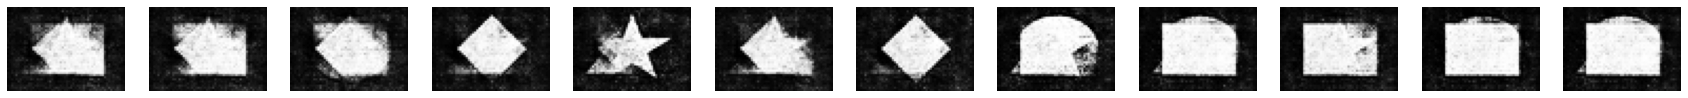

Epoch 151/500 D Loss: 0.0414(r/f: 0.0414 + category: 1.8255) G Loss: 6.4161, RMSE:0.0031 , C loss0.7772, acc, 0.1625 IC real.1.0000, fake: 0.3375
true label, [4. 4. 4. 3. 4. 2. 4. 2. 0.]
image saved [3. 4. 4. 4. 3. 4. 2. 4. 2. 0. 2. 0. 4. 1. 1. 1. 1. 4. 0. 0.]


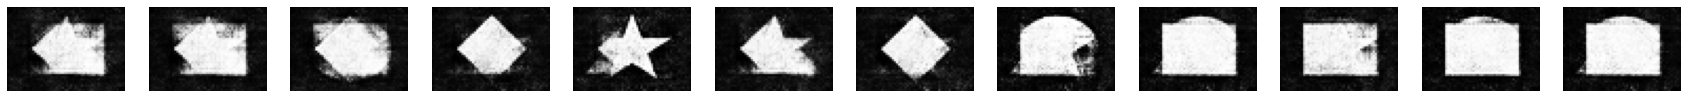

Epoch 201/500 D Loss: 0.0429(r/f: 0.0429 + category: 1.9008) G Loss: 5.9517, RMSE:0.0030 , C loss0.7701, acc, 0.1750 IC real.1.0000, fake: 0.3250
true label, [4. 4. 4. 3. 4. 2. 4. 2. 0.]
image saved [3. 4. 4. 4. 3. 4. 2. 4. 2. 0. 2. 0. 4. 1. 1. 1. 1. 4. 0. 0.]


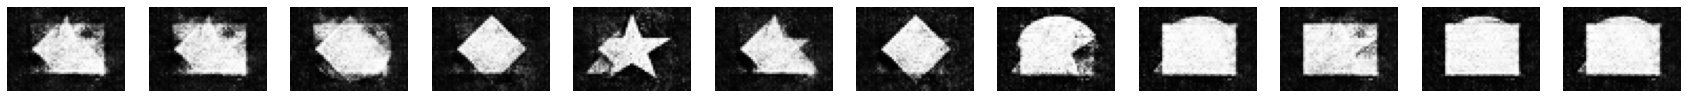

Epoch 251/500 D Loss: 0.0069(r/f: 0.0069 + category: 2.1948) G Loss: 8.9760, RMSE:0.0031 , C loss0.7818, acc, 0.1625 IC real.1.0000, fake: 0.3000
true label, [4. 4. 4. 3. 4. 2. 4. 2. 0.]
image saved [3. 4. 4. 4. 3. 4. 2. 4. 2. 0. 2. 0. 4. 1. 1. 1. 1. 4. 0. 0.]


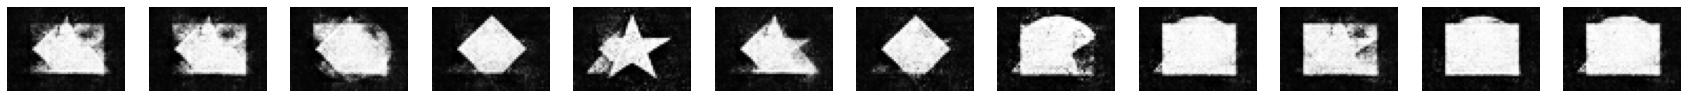

Epoch 301/500 D Loss: 0.0013(r/f: 0.0013 + category: 2.3135) G Loss: 10.8479, RMSE:0.0031 , C loss0.7832, acc, 0.1625 IC real.1.0000, fake: 0.3000
true label, [4. 4. 4. 3. 4. 2. 4. 2. 0.]
image saved [3. 4. 4. 4. 3. 4. 2. 4. 2. 0. 2. 0. 4. 1. 1. 1. 1. 4. 0. 0.]


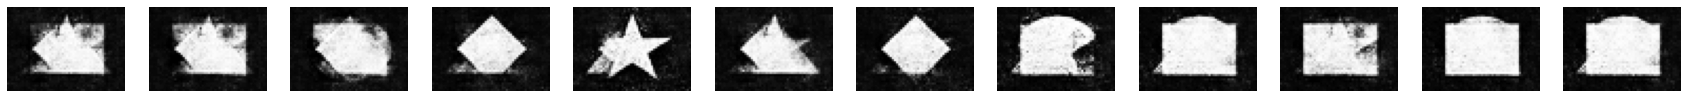

Epoch 351/500 D Loss: 0.0051(r/f: 0.0051 + category: 2.6086) G Loss: 9.4539, RMSE:0.0032 , C loss0.7851, acc, 0.1750 IC real.1.0000, fake: 0.3000
true label, [4. 4. 4. 3. 4. 2. 4. 2. 0.]
image saved [3. 4. 4. 4. 3. 4. 2. 4. 2. 0. 2. 0. 4. 1. 1. 1. 1. 4. 0. 0.]


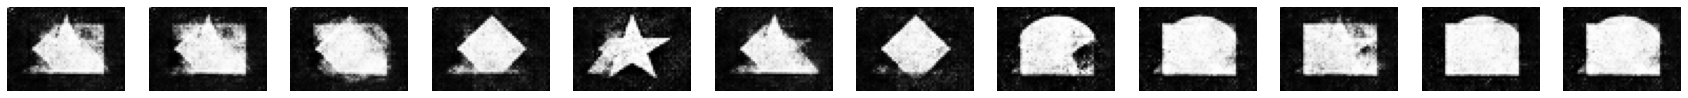

Epoch 401/500 D Loss: 0.0011(r/f: 0.0011 + category: 2.6766) G Loss: 11.1183, RMSE:0.0032 , C loss0.7855, acc, 0.1625 IC real.1.0000, fake: 0.3000
true label, [4. 4. 4. 3. 4. 2. 4. 2. 0.]
image saved [3. 4. 4. 4. 3. 4. 2. 4. 2. 0. 2. 0. 4. 1. 1. 1. 1. 4. 0. 0.]


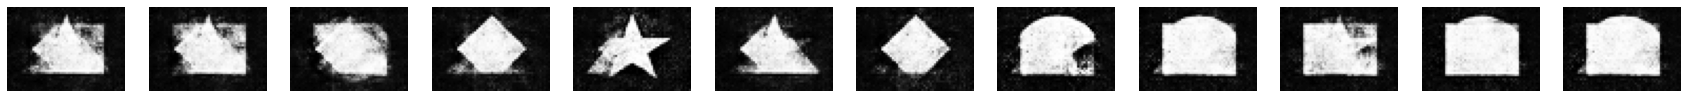

Epoch 451/500 D Loss: 0.0004(r/f: 0.0004 + category: 2.7034) G Loss: 12.5750, RMSE:0.0032 , C loss0.7824, acc, 0.1625 IC real.1.0000, fake: 0.3125
true label, [4. 4. 4. 3. 4. 2. 4. 2. 0.]
image saved [3. 4. 4. 4. 3. 4. 2. 4. 2. 0. 2. 0. 4. 1. 1. 1. 1. 4. 0. 0.]


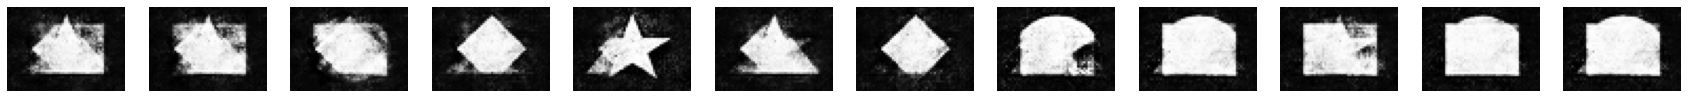

In [ ]:
import pickle

import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt



def one_hot(y_):
    # Function to encode output labels from number indexes
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    y_ = y_.reshape(len(y_))
    y_ = [int(x) for x in y_]
    n_values = np.max(y_) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]


def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    """
    generator
    noise_img: input
    n_units: hidden node number
    out_dim: output size, here is 32*32=784
    alpha: leaky ReLU coefficient
    """
    global n_class
    momentum = 0.9

    with tf.variable_scope("generator", reuse=reuse):
        # Deconvolutional
        noise_img = tf.layers.dense(noise_img, units=140 * 64)

        h0 = tf.reshape(noise_img, [-1, 10, 14, 64])

        h0 = tf.nn.relu(tf.contrib.layers.batch_norm(h0, decay=momentum))

        h3 = tf.layers.conv2d_transpose(h0, kernel_size=5, filters=32, strides=2, padding='same')
        h3 = tf.nn.relu(tf.contrib.layers.batch_norm(h3, decay=momentum))

        h4 = tf.layers.conv2d_transpose(h3, kernel_size=5, filters=1, strides=2, padding='same',
                                        name='g')

        #  logits & outputs
        logits = tf.reshape(h4, [-1, 40 * 56])
        outputs = tf.tanh(logits)
        mid = tf.sigmoid(tf.layers.dense(logits, units=20 * 20))
        pred = tf.layers.dense(mid, units=n_class)

        return logits, outputs, pred


def get_discriminator(img, n_units, reuse=False, alpha=0.01, cond=None):
    momentum = 0.9
    # Select the EEG features from the input conditional featrues
    # the last 40 dimensions are EEG
    con = cond[:, noise_size - 40:noise_size]
    with tf.variable_scope("discriminator", reuse=reuse):
        # CNN
        z_image = tf.reshape(img, [-1, 40, 56, 1])
        h0 = lrelu(tf.layers.conv2d(z_image, kernel_size=5, filters=32, strides=2, padding='same'))
        h0 = lrelu(tf.contrib.layers.batch_norm(h0, decay=momentum))

        h1 = lrelu(tf.layers.conv2d(h0, kernel_size=5, filters=64, strides=2, padding='same'))
        h1 = lrelu(tf.contrib.layers.batch_norm(h1, decay=momentum))

        hidden1 = tf.contrib.layers.flatten(h1)

        hidden1 = tf.concat([hidden1, con], axis=1)  # add the EEG features as conditional information.

        # logits & outputs, discriminative True/False
        logits = tf.layers.dense(hidden1, 1)
        outputs = logits  # tf.tanh(logits)  # normalize the generated image

        # classify 5 categories
        outputs_2 = tf.layers.dense(hidden1, n_class)

        return logits, outputs, outputs_2


def compute_accuracy(v_xs, v_ys):
    correct_prediction = tf.equal(tf.argmax(v_xs, 1), tf.argmax(v_ys, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy


def lrelu(x, leak=0.2):
    return tf.maximum(x, leak * x)


img_size = 40 * 56
noise_size = 60
n_class = 5

"""
load the shuffled data, [3200, 2281], 2286 = 40 + 2240 + 1
In which, 40 is EEG features, 2240 = 40*56 is the image, 1 is the label
"""
data = pickle.load(open('shape_EEG_feature.pkl', 'rb'))

label = data[:, -1]
label.shape = [3200, 1]
# print(np.sum(label), label.shape, np.max(data[0, 40:-1]), np.min(data[0, 40:-1]))

label = one_hot(label)

# make the D_2 label
g_units = 200
d_units = g_units
alpha = 0.01
# label smoothing
smooth = 0.1

tf.reset_default_graph()
real_img = tf.placeholder(tf.float32, [None, img_size], name='real_img')
noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
ground_truth = tf.placeholder(tf.float32, shape=[None, n_class], name='ground_truth')

# generator
g_logits, g_outputs, pred = get_generator(noise_img, g_units, img_size)
# discriminator
d_logits_real, d_outputs_real, real_category_pred = get_discriminator(real_img, d_units, cond=noise_img)
d_logits_fake, d_outputs_fake, fake_category_pred = get_discriminator(g_outputs, d_units, cond=noise_img, reuse=True)

# ACC
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(ground_truth, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# # discriminatorloss # cross-entropy
d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)) * (1 - smooth))
d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))

# reduce_mean
d_loss_rf = tf.add(d_loss_real, d_loss_fake)

d_loss_category_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_category_pred, labels=ground_truth))
d_loss_category_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_category_pred, labels=ground_truth))
d_loss_category = tf.add(0.8 * d_loss_category_real, d_loss_category_fake)
d_loss = d_loss_rf + d_loss_category_real

# classifier loss
c_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=ground_truth))
# calculate the inception classification accuracy, evaluating is the generated image is correct?
IC_fake = compute_accuracy(ground_truth, fake_category_pred)
IC_real = compute_accuracy(ground_truth, real_category_pred)

# generator loss
lambda_ = 0.01
batch_size = 80

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

# regularization of generated fake image with the real image:
g_regular = tf.losses.mean_squared_error(labels=real_img, predictions=g_outputs)
g_loss = g_loss + d_loss_category_fake + lambda_ * g_regular

train_vars = tf.trainable_variables()

# generator tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
learning_rate = 0.0002  # 0.0002
d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=0.5).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=0.5).minimize(g_loss, var_list=g_vars)
c_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(c_loss, var_list=g_vars)

# batch_size
epochs = 500
n_sample = batch_size
n_batch = int(data.shape[0] / batch_size)
#n_batch = 1

samples = []
losses = []

saver = tf.train.Saver(var_list=g_vars)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for h in range(n_batch):
        #print("this is number ", h)
        z_batch = data[batch_size * h:batch_size * (h + 1), 0:40]
        real_image_batch = data[batch_size * h:batch_size * (h + 1), 40:-1]
        label_batch = label[batch_size * h:batch_size * (h + 1)]
        label_batch = label_batch.astype(float)

        # batch_images = batch[0].reshape((batch_size, 784))
        real_image_batch = real_image_batch * 2 - 1
        z_batch = z_batch * 2 - 1

        batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
        batch_noise = np.hstack((batch_noise[:, :20], z_batch[:, :40]))  # 130 noise + 10 EEG channels
        # batch_noise = z_batch[:, :40]

        # Run optimizers
        _ = sess.run(d_train_opt,
                     feed_dict={real_img: real_image_batch, noise_img: batch_noise, ground_truth: label_batch})
        for i in range(2):
            _ = sess.run(g_train_opt,
                         feed_dict={real_img: real_image_batch, noise_img: batch_noise, ground_truth: label_batch})
    #print("e = ", e)
    if e % 50 == 0 and e != 0:
        print("e = ", e)
        # discriminator loss
        train_loss_d, train_loss_d_rf, train_loss_d_category = sess.run([d_loss, d_loss_rf, d_loss_category],
                                                                        feed_dict={real_img: real_image_batch,
                                                                                   noise_img: batch_noise,
                                                                                   ground_truth: label_batch})

        # generator loss
        train_loss_g, train_loss_c, acc, g_regular_ = sess.run([g_loss, c_loss, accuracy, g_regular],
                                                               feed_dict={real_img: real_image_batch,
                                                                          noise_img: batch_noise,
                                                                          ground_truth: label_batch})
        # IC score
        ic_real_, ic_fake_ = sess.run([IC_real, IC_fake],
                                      feed_dict={real_img: real_image_batch, noise_img: batch_noise,
                                                 ground_truth: label_batch})
        print("Epoch {}/{}".format(e + 1, epochs),
              "D Loss: {:.4f}(r/f: {:.4f} + category: {:.4f})".format(train_loss_d, train_loss_d_rf,
                                                                      train_loss_d_category),
              "G Loss: {:.4f}, RMSE:{:.4f} , C loss{:.4f}, acc, {:.4f}".format(train_loss_g,
                                                                    lambda_ * g_regular_, train_loss_c, acc),
              'IC real.{:.4f}, fake: {:.4f}'.format(ic_real_, ic_fake_))
        losses.append((train_loss_d, train_loss_d_rf, train_loss_d_category, train_loss_g), )

        """test  """
        h = n_batch - 3
        z_batch_ = data[batch_size * h:batch_size * (h + 1), :40]  # the last batch worked as testingsample
        true_label = data[batch_size * h:batch_size * (h + 1), -1]
        real_ = data[batch_size * h:batch_size * (h + 1), 40:-1]
        """half noise half EEG"""
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        sample_noise = np.hstack((sample_noise[:, :20], z_batch_[:, :40]))  # 130 noise + 10 EEG channels

        _, gen_samples, pred_ = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                                         feed_dict={real_img: real_image_batch, noise_img: sample_noise, })

        fig = plt.figure(figsize=(30, 6))
        print('true label,', true_label[1:10])
        no_pic = 12
        for i in range(1, no_pic+1):  # 8 samples including 5 categories
            generated_image = gen_samples[i].reshape([40, 56])
            real_image = real_[i].reshape([40, 56])
            fig.add_subplot(1, no_pic, i)
            plt.axis('off')
            plt.imshow(generated_image, cmap='gray_r')
        plt.savefig('generated_images/step'+str(e)+'.png', format='png', bbox_inches='tight')
        pickle.dump(gen_samples, open('GAN_1.pk', 'wb'))

        """Save all the images"""
        for j in range(10):
            #print("Saving image_",e,"_",j)
            im = gen_samples[j].reshape([40, 56])
            Image.fromarray(im, mode='L').save('generated_images/' + str(e) + '_' + str(j) + '.jpg')

        print('image saved', true_label[0:20])
        plt.imshow(im, cmap='gray_r')
        plt.savefig('generated_images/images/step' + str(j) + '.png', format='png', bbox_inches='tight')

        plt.show()
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

In [ ]:
from google.colab import files
files.download( "generated_images/1_0.jpg" )  